In [ ]:
import sys
sys.path.append('../..')
from src.data_notebook import *
from src.utils import *
from src.models import *
from contrib.IMT.SPDE.lit_model_spde import *
from contrib.IMT.SPDE.models_spde import *

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ssh_ = xr.open_dataset("/Odyssey/private/m19beauc/IMT/data/natl_gf_w_5nadirs_swot_woi.nc").isel(time=slice(212,215)).sel(lon=slice(-65., -55.),lat=slice(33.,43.))
ssh_ = ssh_.coarsen(lon=4,boundary='pad').mean().coarsen(lat=4,boundary='pad').mean()
ssh = torch.unsqueeze(torch.tensor((ssh_.ssh-ssh_.ssh_mod).values),0)
plt.pcolormesh(np.arange(50),np.arange(50),ssh[0,0,:,:].cpu().numpy())
plt.show()
test = 3*(torch.abs(kfilts.spatial_gradient(torch.unsqueeze(torch.tensor(ssh_.ssh.values),dim=0),normalized=True)[0,:,1,:,:])+\
torch.abs(kfilts.spatial_gradient(torch.unsqueeze(torch.tensor(ssh_.ssh.values),dim=0),normalized=True)[0,:,0,:,:]))+.01
#test = 10*(torch.abs(ssh[0])+0.01)
plt.pcolormesh(np.arange(50),np.arange(50),test[0,:,:])
plt.show()
plt.pcolormesh(np.arange(50),np.arange(50),test[1,:,:])
plt.show()
plt.pcolormesh(np.arange(50),np.arange(50),test[2,:,:])
plt.show()

In [43]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

n_b, n_t, n_y, n_x = [1,3,50,50]
nb_nodes = n_x*n_y
dx = dy = dt = 1

theta = [torch.zeros((n_b,1,n_y*n_x,n_t)).to(device),
         torch.zeros((n_b,2,n_y*n_x,n_t)).to(device),
         torch.zeros((n_b,2,2,n_y*n_x,n_t)).to(device),
         torch.zeros((n_b,1,n_y*n_x,n_t)).to(device)]

theta[0][0,:,:,:] = .1
theta[1][0,0,:,:] =  10.
theta[2][0,0,0,:,:] = 10000
theta[2][0,0,1,:,:] = 100
theta[2][0,1,0,:,:] = 100
theta[2][0,1,1,:,:] = 100

theta[3][0,0,:,0] = torch.reshape(test[0],(nb_nodes,))
theta[3][0,0,:,1] = torch.reshape(test[1],(nb_nodes,))
theta[3][0,0,:,2] = torch.reshape(test[2],(nb_nodes,))


# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)
pow=4./2

spde_fdm = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,100,100],
                  pow=pow,spde_type='adv_diff',scheme="FDM")
    
Q_fdm = spde_fdm(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)[0]

spde_fudm1 = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,100,100],
                  pow=pow,spde_type='adv_diff',scheme="FUDM1")
    
Q_fudm1 = spde_fudm1(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)[0]

print(spde_fdm.dx,spde_fdm.dy,spde_fdm.dt)

n_simu = 10
Q_fdm_ = Q_fdm.detach().cpu()
Q_sp_fdm = sparse_torch2scipy(Q_fdm_)
factor_fdm = cholesky(Q_sp_fdm,ordering_method='natural')
Q_fudm1_ = Q_fudm1.detach().cpu()
Q_sp_fudm1 = sparse_torch2scipy(Q_fudm1_)
factor_fudm1 = cholesky(Q_sp_fudm1,ordering_method='natural')
rand = torch.randn(nb_nodes*n_t,n_simu)
RM_fdm = factor_fdm.apply_P(rand)
RM_fudm1 = factor_fudm1.apply_P(rand)
x_simu_fdm_ = torch.FloatTensor(factor_fdm.solve_Lt(RM_fdm,
                                                    use_LDLt_decomposition=False)).to(device)
x_simu_fudm1_ = torch.FloatTensor(factor_fudm1.solve_Lt(RM_fudm1,
                                                    use_LDLt_decomposition=False)).to(device)
x_simu_fdm = torch.reshape(x_simu_fdm_,(n_t,n_x,n_y,n_simu))
x_simu_fudm1 = torch.reshape(x_simu_fudm1_,(n_t,n_x,n_y,n_simu))

tensor(100) tensor(100) tensor(1)


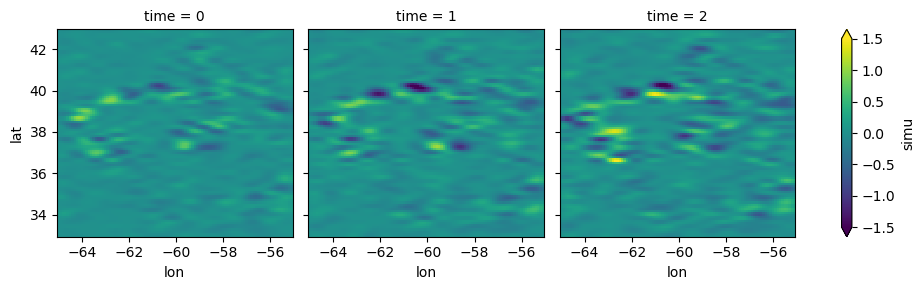

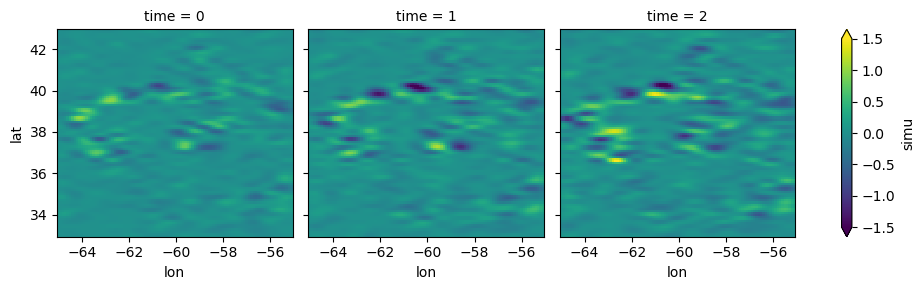

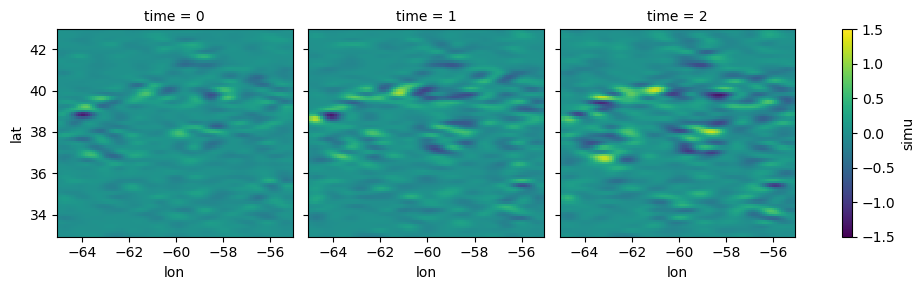

In [44]:
from IPython.display import clear_output

class Upsampler(nn.Module):
    def __init__(self, scale_factor, mode, align_corners, antialias, **kwargs):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners
        self.antialias = antialias
        
    def forward(self, x):  
        x = F.interpolate(torch.unsqueeze(x,dim=0), scale_factor=self.scale_factor,
                          mode=self.mode, align_corners=self.align_corners,
                          antialias=self.antialias)
        x = torch.squeeze(x)
        return x
    
up = Upsampler(scale_factor=2,
                     mode='bilinear',
                     align_corners=False,
                     antialias=True)

xr.Dataset(data_vars={'simu':(('time','lat','lon'),up(np.reshape(x_simu_fdm[:3,:,:,0].detach().cpu(),(3,50,50))))},
           coords={'time':np.arange(3),
                   'lon':np.arange(-65, -55, 0.1),
                   'lat':np.arange(33, 43, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),up(np.reshape(x_simu_fudm1[:3,:,:,0].detach().cpu(),(3,50,50))))},
           coords={'time':np.arange(3),
                   'lon':np.arange(-65, -55, 0.1),
                   'lat':np.arange(33, 43, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),up(np.reshape(x_simu_fudm1[:3,:,:,5].detach().cpu(),(3,50,50))))},
           coords={'time':np.arange(3),
                   'lon':np.arange(-65, -55, 0.1),
                   'lat':np.arange(33, 43, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()

In [212]:
def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size).to(device)
    if len(val.size())==0:
        values = (val.expand(size)).to(device)
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])).to(device)

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.LongTensor(size*n1,size*n2).to(device)


class Encoder(torch.nn.Module):

    def __init__(self,shape_data):
        super(Encoder, self).__init__()
        self.n_t, self.n_y, self.n_x  = shape_data
        self.cnn = torch.nn.Conv2d(self.n_t,8*self.n_t,(3,3),padding=1,bias=False)

    def forward(self, x):
        # input shape (b,t,y,x) --> output shape (b,7*t,y,x)
        theta = self.cnn(x)
        # activation functions on some parameters
        return theta

class NLL_new(torch.nn.Module):

    def __init__(self, shape_data, st_lag=[1,1,1], trainable_lag=False,
                 pow=1, spde_type="adv_diff", scheme="FUDM1",crop=None, downsamp=None):

        super(NLL_new,self).__init__()
        self.spde_type = spde_type
        self.scheme = scheme
        self.pow = pow        
        self.crop = crop
        self.downsamp = downsamp
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )
        self.trainable_lag = trainable_lag
        if crop is not None:
            shape_data = [shape_data[0],
                          shape_data[1]-self.crop,
                          shape_data[2]-self.crop]
            
        if downsamp is not None:
            shape_data = [shape_data[0],
                          shape_data[1]//self.downsamp,
                          shape_data[2]//self.downsamp] 
        
        self.encoder = Encoder(shape_data)
        
        self.operator_spde = Prior_SPDE(shape_data,st_lag,
                                        trainable_lag=self.trainable_lag,
                                        pow=self.pow,
                                        spde_type=self.spde_type,
                                        scheme=self.scheme)
        
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const
        
    def reshape_params(self,theta):

        n_b, n_t, n_x, n_y = theta.shape
        n_t = theta.shape[1]//8

        # reshape the parameters
        kappa = theta[:,:n_t,:,:]
        tau = theta[:,n_t:2*n_t,:,:]
        m1 = theta[:,2*n_t:3*n_t,:,:]
        m2 = theta[:,3*n_t:4*n_t,:,:]
        vx = theta[:,4*n_t:5*n_t,:,:]
        vy = theta[:,5*n_t:6*n_t,:,:]
        gamma = theta[:,6*n_t:7*n_t,:,:]
        beta = theta[:,7*n_t:8*n_t,:,:]
        
        H = []
        for k in range(n_t):
            vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
            vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
            vxy = torch.stack([vx_,vy_],dim=2)
            vxyT = torch.permute(vxy,(0,2,1))
            gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
            beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
            H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
            H.append(H_)
        H = torch.stack(H,dim=4)
        m = torch.stack([m1,m2],dim=1)

        kappa = torch.permute(kappa,(0,2,3,1))
        tau = torch.permute(tau,(0,2,3,1))
        m = torch.permute(m,(0,1,3,4,2))
        H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
        H = torch.permute(H,(0,1,2,3,4,5))

        # reshaping n_x,n_y -> n_x*n_y
        kappa = torch.reshape(kappa,(n_b,1,n_y*n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y*n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y*n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y*n_x,n_t))

        #H = torch.full(H.shape,0.).to(device)
        return [kappa, m, H, tau]
    
    def downsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,n_y//self.downsamp,n_x//self.downsamp,n_t))
        
        kappa = torch.reshape(kappa,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        tau = torch.reshape(tau,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        m = torch.reshape(m,(n_b,2,nb_nodes//(self.downsamp**2),n_t))
        H = torch.reshape(H,(n_b,2,2,nb_nodes//(self.downsamp**2),n_t))
        
        return kappa, m, H, tau
    
    def upsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,int(n_y*self.downsamp),
                                                                      int(n_x*self.downsamp),n_t))

        kappa = torch.reshape(kappa,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        tau = torch.reshape(tau,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        m = torch.reshape(m,(n_b,2,int(nb_nodes*(self.downsamp**2)),n_t))
        H = torch.reshape(H,(n_b,2,2,int(nb_nodes*(self.downsamp**2)),n_t))
        
        return kappa, m, H, tau
    

    def forward(self, x, theta=None, mu=None, det=True):

        n_b, n_t, n_x, n_y = x.shape

        # compute the parameters
        if theta is None:
            theta = self.encoder(x)
            
        if not isinstance(theta, list):
            kappa, m, H, tau = self.reshape_params(theta)
        else:
            kappa, m, H, tau = theta
        
        # compute Q(theta)
        if self.crop is not None:
            c = self.crop//2
            x = x[:,:,c:-c,c:-c]
            if mu is not None:
                mu = mu[:,:,c:-c,c:-c]
            kappa = torch.reshape(torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            tau = torch.reshape(torch.reshape(tau,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            m = torch.reshape(torch.reshape(m,(n_b,2,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            H = torch.reshape(torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))[:,:,:,c:-c,c:-c,:],
                                   (n_b,2,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            n_b, n_t, n_y, n_x = x.shape
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.downsamp_params(kappa, m, H, tau, sp_dims=[n_y, n_x])
            
        Q, block_diag = self.operator_spde(kappa,
                                           m,
                                           H,
                                           tau,
                                           store_block_diag=True)
        
        # compute determinant(Q)
        if det==True:
            det_Q = list()
            for i in range(n_b):
                log_det = 0.
                for j in range(0,len(block_diag[i])):
                    BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                    #chol_block = torch.linalg.cholesky(BD)
                    chol_block, info = torch.linalg.cholesky_ex(BD)
                    if info!=0:
                        return torch.tensor([np.nan for _ in range(n_b)])
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         chol_block,
                                         0)\
                                        )\
                                       )
                    log_det += log_det_block
                # log(det(Q^k)) = sum_k=1^p log(det(Q))
                log_det = int(2*self.pow)*log_det
                det_Q.append(log_det)

        # compute Mahanalobis distance xT.Q.x
        MD = list()
        for i in range(n_b):
            if self.downsamp is None:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i],(1,n_t*n_x*n_y)),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i]-mu[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i]-mu[i],(1,n_t*n_x*n_y)),MD_)
            else:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i]-self.down(mu)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i]-self.down(mu)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
            MD.append(MD_[0,0])

        # Negative log-likelihood
        if det==True:
            log_det = torch.stack(det_Q)
        MD = torch.stack(MD)

        # NLL is -log[p_theta(x)] has size (#batch,1)
        # GradNLL (with autodiff) will have same dim as x
        if det==True:
            NLL = -1.*(log_det - MD)
        else:
            NLL = -1.*MD
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.upsamp_params(kappa, m, H, tau, sp_dims=[n_y//self.downsamp, n_x//self.downsamp])
            

        return NLL

In [213]:
nll = NLL_new(shape_data=[3,50,50],
                                                           pow=2./2., spde_type="adv_diff",
                                                           trainable_lag=False,
                                                           scheme="FUDM1", downsamp=2, crop=None,st_lag=[1,50,50])

In [214]:
print(theta[3].shape)
nll1 = nll(torch.unsqueeze(torch.reshape(x_simu_fudm1[:3,:,:,5].detach(),(3,50,50)),dim=0), theta, mu = None, det=True)
nll2 = nll(torch.unsqueeze(torch.reshape(x_simu_fudm1[:3,:,:,9].detach(),(3,50,50)),dim=0), theta, mu = None, det=True)
nll3 = nll(ssh.to(device), theta, mu = None, det=True)

print(nll1, nll2, nll3)

torch.Size([1, 1, 2500, 3])
tensor([15598.7324], device='cuda:0') tensor([10206.2441], device='cuda:0') tensor([28447.7195], device='cuda:0', dtype=torch.float64)
